# Interpretability of autoencoder latent space for passengers demand-sensitive planning on high-speed railways (IWANN 2023)


In [1]:
import datetime
import math
import nltk
import numpy as np
import os
import pandas as pd
import random

from feature_engine.creation import CyclicalFeatures
from nltk.corpus import wordnet
from scipy import spatial
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from typing import Dict, List, Tuple

EMBEDDING_DIM = 50

In [2]:
# Download wordnet if not already downloaded
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/david/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
from src.robin.supply.entities import Supply

def get_paths_from_supply(path_config_supply: str = '../configs/test_case/supply_data.yml') -> List[List[str]]:
    """
    Get the paths of a supply

    Args:
        path_config_supply (str, optional): Path to the supply config file. Defaults to '../configs/test_case/supply_data.yml'.

    Returns:
        List[List[str]]: List of paths
    """
    supply = Supply.from_yaml(path_config_supply)

    # Get set of corridors
    corridors = []
    for service in supply.services:
        if service.line.corridor not in corridors:
            corridors.append(service.line.corridor)

    # Get set of paths
    paths = []
    for corridor in corridors:
        for path in corridor.paths:
            if path not in paths:
                paths.append(path)

    # Parse paths of Station objects to paths of station mame
    paths = [[station.name.replace("-", " ").split(" ")[0].lower() for station in path] for path in paths]
    return paths

paths = get_paths_from_supply()
print(paths)

[['madrid', 'guadalajara', 'calatayud', 'zaragoza', 'lleida', 'tarragona', 'barcelona', 'girona', 'figueres']]


In [4]:
def get_word_syn(word: str) -> str:
    """
    Get a random synonym of a word

    Args:
        word (str): Word to get the synonym from

    Returns:
        str: Synonym of the word
    """
    word_synset = wordnet.synsets(word)
    if len(word_synset) > 0:
        station_synset = word_synset[0]
        station_lemmas = station_synset.lemmas()
        if len(station_lemmas) > 0:
            word_lemma = random.choice(station_lemmas)
            return word_lemma.name().lower()

    return word

def get_random_pair(paths: list[list]) -> Tuple[str, str]:
    """
    Get a random pair of stations from a path

    Args:
        paths (list[list]): List of stations

    Returns:
        Tuple[str, str]: Tuple with the origin and destination stations
    """
    random_path = random.choice(paths)  # Choose a random path

    origin_index = random.randint(0, len(random_path) - 2)  # Choose a random origin station
    destination_index = random.randint(origin_index + 1, len(random_path) - 1)  # Choose a random destination station

    origin_station = random_path[origin_index]
    destination_station = random_path[destination_index]
    return origin_station, destination_station

In [5]:
def get_renfe_station_id(adif_id: str, stations_df: pd.DataFrame) -> str:
    """
    Returns the Station name given the Adif station id.

    Args:
        adif_id (str): Adif station id.
        stations_df (pd.DataFrame): Dataframe with the stations' information.

    Returns:
        str: Station name.
    """
    station_name = stations_df[stations_df['stop_id'] == adif_id]['stop_name'].values[0]
    station_name = station_name.replace("-", " ").split(" ")[0].lower()
    return station_name

stations_csv_path = f'../data/renfe/renfe_stations.csv'
stations_df = pd.read_csv(stations_csv_path, dtype={'stop_id': str, 'renfe_id': str})

In [6]:
def simulate_passengers_data(paths: list,
                             user_patterns: list,
                             n_passengers: int = 10000,
                             seed: int = 42
    ) -> pd.DataFrame:
    # Set random state
    random.seed(seed)

    pairs = []
    for _ in range(n_passengers):
        pairs.append(get_random_pair(paths))

    df = pd.DataFrame(pairs, columns=['origin', 'destination'])
    df['user_pattern'] = [random.choice(user_patterns) for _ in range(n_passengers)]

    random_days = lambda: random.randint(0, 365*10)
    random_hours = lambda: random.randint(0, 24)
    random_minutes = lambda: random.randint(0,60)

    random_timedelta = lambda: datetime.timedelta(days=random_days(), hours=random_hours(), minutes=random_minutes())
    df['arrival_date'] = [datetime.datetime(2021, 1, 1) + random_timedelta() for _ in range(n_passengers)]
    df['week_day'] = [date.strftime('%A').lower() for date in df['arrival_date']]
    df['month'] = [date.strftime('%B').lower() for date in df['arrival_date']]
    df['time'] = [date.time() for date in df['arrival_date']]
    df.drop(columns=['arrival_date'], inplace=True)
    return df

user_patterns = ("business", "student", "tourist")
df = simulate_passengers_data(paths, user_patterns, n_passengers=10000)
print(df.head())

        origin  destination user_pattern   week_day    month      time
0       madrid    tarragona      tourist     monday      may  14:39:00
1     zaragoza    tarragona     business    tuesday  january  23:52:00
2  guadalajara    barcelona     business     friday   august  01:46:00
3       madrid  guadalajara      student  wednesday   august  07:48:00
4     zaragoza    tarragona      student     monday   august  04:15:00


In [38]:
class AutoencoderEmbedding:
    """
    Class to get the embedding of a dataframe to be used as input of an autoencoder

    Attributes:
        df (pd.DataFrame): Dataframe with the data to be embedded
        df_embedding (pd.DataFrame): Dataframe with the embedding.
        embedding_dim (int, optional): Embedding dimension. Defaults to 50.
        embedding_dict (dict): Dictionary with the embedding.
        scaler (MinMaxScaler): Scaler to normalize the data.
        cyclical (CyclicalFeatures): Cyclical features transformer.
        df_time (pd.DataFrame): Dataframe with the time embedding.
        input_arrays (list[np.array]): List of arrays with the embedded input data.
    """
    def __init__(self, df: pd.DataFrame, embedding_dim: int = 50):
        """
        Constructor method

        Args:
            df (pd.DataFrame): Dataframe with the data to be embedded
            embedding_dim (int, optional): Embedding dimension. Defaults to 50.
        """
        self.df = df
        self.embedding_dim = embedding_dim
        self.embedding_dict = self._get_embedding_dict()
        self.scaler = MinMaxScaler()
        self.cyclical = CyclicalFeatures(variables=['time'], drop_original=True)
        self.df_embedding = self._get_input_arrays()
        self.words_embeddings = self._get_words_embedding()
        self.time_embedding = self._get_time_embedding()

    def _get_words_embedding(self):
        input_data = self.df_embedding[['origin', 'destination', 'user_pattern', 'week_day', 'month']].values.tolist()
        return np.array([np.asarray(row, dtype=np.float32) for row in input_data])

    def _get_time_embedding(self):
        input_data = self.df_embedding[['time']].values.tolist()
        return np.array([np.asarray(row, dtype=np.float32) for row in input_data])

    def _get_embedding_dict(self) -> Dict[str, np.array]:
        """
        Get the words embedding dictionary

        Returns:
            Dict[str, np.array]: Dictionary with the embedding.
        """
        # Get bag of words
        words_set = set(self.df[['origin', 'destination', 'user_pattern', 'week_day', 'month']].values.flatten())
        word_index = {word: index for index, word in enumerate(words_set)}

        embeddings_index = {}
        f = open(os.path.join('../data/pretrained/glove6B/glove.6B.50d.txt'))

        # Read GloVe embeddings
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype=np.float32)
            embeddings_index[word] = coefs
        f.close()

        # Create embedding matrix
        embedding_matrix = np.zeros((len(word_index) + 1, self.embedding_dim))
        embedding_dict = {}
        for word, i in word_index.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                embedding_dict[word] = embedding_vector

        return embedding_dict

    def decode_time_embedding(self, time_embedding: np.array) -> datetime.time:
        """
        Decode the time embedding

        Args:
            time_embedding (np.array): Time embedding

        Returns:
            datetime.time: Time
        """

        """
        degrees = math.degrees(math.acos(time_embedding))
        total_minutes = (degrees / 360) * (24 * 60)
        hours = int(total_minutes / 60)
        minutes = int(total_minutes % 60)
        time = datetime.time(hour=hours, minute=minutes)
        """
        total_minutes = self.scaler.inverse_transform(time_embedding)
        hours = int(total_minutes / 60)
        minutes = int(total_minutes % 60)
        time = datetime.time(hour=hours, minute=minutes)
        return time

    def _get_input_arrays(self) -> np.array:
        """
        Get the input arrays

        Returns:
            np.array: Array with the embedded input data.
        """
        df_embedding = pd.DataFrame()
        df_embedding['origin'] = self.df['origin'].apply(lambda x: self.embedding_dict.get(x))
        df_embedding['destination'] = self.df['destination'].apply(lambda x: self.embedding_dict.get(x))
        df_embedding['user_pattern'] = self.df['user_pattern'].apply(lambda x: self.embedding_dict.get(x))
        df_embedding['week_day'] = self.df['week_day'].apply(lambda x: self.embedding_dict.get(x))
        df_embedding['month'] = self.df['month'].apply(lambda x: self.embedding_dict.get(x))

        def encode_time(time: datetime.datetime) -> np.float32:
            total_minutes = (time.hour * 60) + time.minute
            total_degrees = (total_minutes / (24 * 60)) * 360
            encoded_value = math.sin(math.radians(total_degrees))
            return np.float32(encoded_value)

        def total_minutes(time: datetime.datetime) -> np.float32:
            total_minutes = (time.hour * 60) + time.minute
            return np.float32(total_minutes)
        df_embedding['time'] = self.df['time'].apply(lambda x: total_minutes(x))
        df_embedding['time'] = self.scaler.fit_transform(df_embedding[['time']])

        return df_embedding[['origin', 'destination', 'user_pattern', 'week_day', 'month', 'time']]

In [39]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)

print("Train data shape: ", df_train.shape)
print("Test data shape: ", df_test.shape)

train_embedding = AutoencoderEmbedding(df = df_train, embedding_dim=EMBEDDING_DIM)
test_embedding = AutoencoderEmbedding(df = df_test, embedding_dim=EMBEDDING_DIM)

print("Test data autoencoder input shape: ", test_embedding.words_embeddings.shape)
print("First test data instance: ", test_embedding.df.iloc[0])
print("First test data instance embedded: ", test_embedding.words_embeddings[0])

Train data shape:  (7000, 6)
Test data shape:  (3000, 6)
Test data autoencoder input shape:  (3000, 5, 50)
First test data instance:  origin          zaragoza
destination       lleida
user_pattern     student
week_day          sunday
month               june
time            22:10:00
Name: 6252, dtype: object
First test data instance embedded:  [[ 1.0642    0.089939 -0.28715   0.82471   0.31063  -1.4798    0.12028
   0.7449   -1.2919    0.39737   0.4715   -0.53483  -0.48049  -1.2998
   0.32826  -1.3085   -0.67916  -0.20625  -0.7232    0.41638  -1.2895
  -0.69963  -0.23631   0.70175  -0.61498   0.20193   1.329     0.25294
  -0.093715 -0.16535   0.99605   1.2007   -0.26729  -0.42035  -0.15881
   0.63906  -0.73977   1.3119    0.61136  -0.59197   1.3032    0.16094
  -0.027686 -0.9412   -0.68288   0.65116   0.47976  -0.32516   1.3912
  -0.50467 ]
 [ 0.23779  -0.70155  -1.123     0.36108  -1.1387   -0.49992   0.28795
   0.87089  -0.32366   0.85312   1.5365   -1.2579    0.45029  -0.87621
  -0.

## Embedding Model

## Autoencoder model

In [40]:
import tensorflow as tf
from tensorflow.keras.layers import Concatenate, Conv1D,Conv1DTranspose, Dense, Flatten, GlobalMaxPooling1D, GRU, Input, RepeatVector, Reshape, TimeDistributed
from tensorflow.keras.models import Model

words_embeddings_shape = (5, EMBEDDING_DIM)
time_embedding_shape = (1,)

SEQUENCE_LENGTH = 5

latent_dim = 5

# Encoder model
input_words = Input(shape=words_embeddings_shape)

conv1 = Conv1D(64, kernel_size=3, activation='relu', padding='same')(input_words)
conv2 = Conv1D(32, kernel_size=3, activation='relu', padding='same')(conv1)
pooling = GlobalMaxPooling1D()(conv2)
flat_layer = Flatten()(pooling)

input_time = Input(shape=time_embedding_shape)
concat_layer = Concatenate(axis=1)([flat_layer, input_time])

encoder = Dense(64)(concat_layer)
encoder = Dense(32)(encoder)

dense1 = Dense(latent_dim)(encoder)

# Decoder model
decoder_inputs = Input(shape=(latent_dim,))
dense3 = Dense(32)(decoder_inputs)
dense4 = Dense(64)(dense3)

repeat_vector = RepeatVector(6)(Flatten()(dense4))

decoder = Dense(32 * SEQUENCE_LENGTH, activation='relu')(dense4)
decoder = Reshape((SEQUENCE_LENGTH, 32))(decoder)
decoder = Conv1DTranspose(32, kernel_size=3, activation='relu', padding='same')(decoder)
decoder = Conv1DTranspose(64, kernel_size=3, activation='relu', padding='same')(decoder)
decoder_words = Conv1DTranspose(EMBEDDING_DIM, kernel_size=3, padding='same')(decoder)

decoder_time = Dense(1)(dense4)

encoder_model = Model(inputs=[input_words, input_time], outputs=dense1)
decoder_model = Model(inputs=decoder_inputs, outputs=[decoder_words, decoder_time])

decoded_words, decoded_time = decoder_model(dense1)
model = Model(inputs=[input_words, input_time], outputs=[decoded_words, decoded_time])

model.compile(optimizer='rmsprop', loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 5, 50)]      0           []                               
                                                                                                  
 conv1d_4 (Conv1D)              (None, 5, 64)        9664        ['input_7[0][0]']                
                                                                                                  
 conv1d_5 (Conv1D)              (None, 5, 32)        6176        ['conv1d_4[0][0]']               
                                                                                                  
 global_max_pooling1d_2 (Global  (None, 32)          0           ['conv1d_5[0][0]']               
 MaxPooling1D)                                                                              

In [41]:
history = model.fit(x = [train_embedding.words_embeddings, train_embedding.time_embedding],
                    y = [train_embedding.words_embeddings, train_embedding.time_embedding],
                    epochs=10,
                    batch_size=32,
                    verbose=1)

Epoch 1/10
219/219 [==============================] - 2s 2ms/step - loss: 0.1654 - model_7_loss: 0.1325 - model_7_1_loss: 0.0329 - model_7_mean_squared_error: 0.1325 - model_7_1_mean_squared_error: 0.0329
Epoch 2/10
219/219 [==============================] - 1s 2ms/step - loss: 0.0757 - model_7_loss: 0.0719 - model_7_1_loss: 0.0038 - model_7_mean_squared_error: 0.0719 - model_7_1_mean_squared_error: 0.0038
Epoch 3/10
219/219 [==============================] - 1s 2ms/step - loss: 0.0562 - model_7_loss: 0.0536 - model_7_1_loss: 0.0026 - model_7_mean_squared_error: 0.0536 - model_7_1_mean_squared_error: 0.0026
Epoch 4/10
219/219 [==============================] - 1s 2ms/step - loss: 0.0460 - model_7_loss: 0.0439 - model_7_1_loss: 0.0021 - model_7_mean_squared_error: 0.0439 - model_7_1_mean_squared_error: 0.0021
Epoch 5/10
219/219 [==============================] - 1s 2ms/step - loss: 0.0397 - model_7_loss: 0.0380 - model_7_1_loss: 0.0017 - model_7_mean_squared_error: 0.0380 - model_7_1_me

## Plot history

In [11]:
history.history.keys()

dict_keys(['loss', 'model_1_loss', 'model_1_1_loss', 'model_1_mean_squared_error', 'model_1_1_mean_squared_error'])

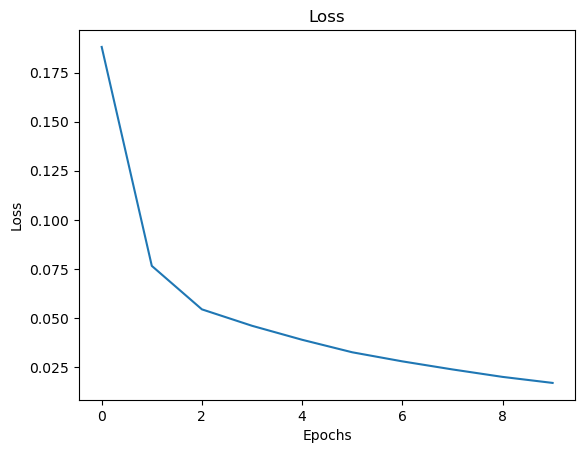

In [36]:
# Plot history loss and mse

import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [13]:
# Evaluate model
score = model.evaluate(x=[test_embedding.words_embeddings, test_embedding.time_embedding],
                       y=[test_embedding.words_embeddings, test_embedding.time_embedding],
                       verbose=1)

94/94 [==============================] - 0s 2ms/step - loss: 0.0164 - model_1_loss: 0.0160 - model_1_1_loss: 4.0501e-04 - model_1_mean_squared_error: 0.0160 - model_1_1_mean_squared_error: 4.0501e-04


## Make predictions

In [42]:
def find_closest_embeddings(embedding, emb):
    return sorted(emb.keys(), key=lambda word: spatial.distance.euclidean(emb[word], embedding))[0]

In [48]:
random_index = np.random.randint(0, test_embedding.df.shape[0])

random_words_embedding = test_embedding.words_embeddings[random_index:random_index+1]
random_time_embedding = test_embedding.time_embedding[random_index:random_index+1]

print("Input - Random passenger data: ")
print(test_embedding.df.iloc[random_index])

prediction = model.predict(x = [random_words_embedding, random_time_embedding])

print("Output - Passenger reconstruction: ")
decoded_words = [find_closest_embeddings(word_vector, test_embedding.embedding_dict) for word_vector in prediction[0][0]]
print(decoded_words)

print("Time prediction: ")
predicted_time = test_embedding.decode_time_embedding([prediction[1][0]])
print(predicted_time)

Input - Random passenger data: 
origin          calatayud
destination        girona
user_pattern     business
week_day        wednesday
month             january
time             08:59:00
Name: 4011, dtype: object
1/1 [==============================] - 0s 16ms/step
Output - Passenger reconstruction: 
['calatayud', 'girona', 'business', 'thursday', 'october']
Time prediction: 
09:07:00


Mes y día como palabra, hora pensar idea para representar (ángulo?)

## Estudio de la correlación entre factores latentes y la entrada del autoencoder